# Project 4, APS1070 Fall 2020
#### **Linear Regression -  20 points**
**Deadline: Nov 29, 23:59**

**Academic Integrity**

This project is individual - it is to be completed on your own. If you have questions, please post your query in the APS1070 Piazza Q&A forums (the answer might be useful to others!).

Do not share your code with others, or post your work online. Do not submit code that you have not written yourself. Students suspected of plagiarism on a project, midterm or exam will be referred to the department for formal discipline for breaches of the Student Code of Conduct.

Please fill out the following:


*   Your **name**: Kangni Wang
*   Your **student number**: 1006783562



## Part 1 - Getting Started [1 mark]

In Parts 1- 6 of this project, we are designing a controller to manage the ailerons of an F16 Aircraft! 

![Ailerons](https://raw.githubusercontent.com/aps1070-2019/datasets/master/img/airplane.gif) [Ref](https://www.grc.nasa.gov/www/k-12/BGA/Mike/airplane_parts_act.htm) 


The features describe the airplane's status, and our goal is to predict the `Goal` column, which is a command that our controller should issue. We will make our predictions by implementing linear regression without regularization.

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from scipy.linalg import inv
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge

In [2]:
df=pd.read_csv("https://raw.githubusercontent.com/aps1070-2019/datasets/master/F16L.csv" , skipinitialspace=True)

1. Print the dataframe.
2. Prepare your dataset as follows: **[1]**
*   Split the dataset into training and validation sets (80% training, 20% validation). When splitting, set `random_state=1`.
*   Standardize the data using StandardScaler from sklearn.
*   Insert a first column of 1s in both the training and validation data sets.


In [3]:
# Print the dataframe
df

,inputs ClimbRate,Sgz,P,Q,CurPitch,CurRoll,AbsRoll,DiffClb,DiffRollRate,DiffDiffClb,SeTime1,SeTime2,SeTime3,SeTime4,SeTime5,SeTime6,SeTime7,SeTime8,SeTime9,SeTime10,SeTime11,SeTime12,SeTime13,SeTime14,DiffSeTime1,DiffSeTime2,DiffSeTime3,DiffSeTime4,DiffSeTime5,DiffSeTime6,DiffSeTime7,DiffSeTime8,DiffSeTime9,DiffSeTime10,DiffSeTime11,DiffSeTime12,DiffSeTime13,DiffSeTime14,Alpha,Se,Goal
0,-17,-6,-0.03,0.14,0.59,-0.5,-11,-9,0.015,-0.2,0.019,0.019,0.019,0.020,0.020,0.020,0.020,0.021,0.021,0.021,0.021,0.021,0.021,0.021,0.000,0.0,-0.002,0.0,0.0,0.0,-0.002,0.0,0.000,0.0,0.000,0.0,0.000,0.0,0.6,0.021,-0.0008
1,-791,15,-0.28,-0.34,1.11,0.9,-10,27,-0.002,4.7,0.013,0.013,0.013,0.013,0.013,0.013,0.013,0.013,0.013,0.013,0.013,0.013,0.013,0.013,0.000,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.000,0.0,0.000,0.0,0.4,0.013,-0.0009
2,-46,48,-0.42,0.07,0.57,0.6,-5,-8,-0.008,0.0,0.018,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.019,-0.002,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.000,0.0,0.000,0.0,0.5,0.019,-0.0005
3,496,-5,-0.21,-0.04,0.03,-0.5,-7,6,-0.002,-0.1,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.018,0.018,0.017,-0.001,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.001,0.0,0.001,0.0,0.5,0.017,-0.0005
4,-124,16,-0.02,0.05,0.61,-0.2,-9,-3,0.000,0.0,0.018,0.018,0.018,0.018,0.018,0.018,0.018,0.018,0.018,0.018,0.018,0.018,0.018,0.018,0.000,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.000,0.0,0.000,0.0,0.5,0.018,-0.0006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13745,-53,-13,-0.07,0.02,0.58,-2.3,-15,12,0.022,-0.8,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.000,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.000,0.0,-0.001,0.0,0.5,0.019,-0.0007
13746,1,4,-0.11,-0.07,0.47,0.8,-5,8,-0.003,-0.2,0.016,0.016,0.016,0.016,0.016,0.016,0.016,0.016,0.016,0.016,0.016,0.016,0.016,0.016,0.000,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.000,0.0,0.000,0.0,0.5,0.016,-0.0004
13747,425,-14,0.40,0.07,0.41,-2.1,-16,12,0.031,-0.7,0.035,0.035,0.035,0.035,0.035,0.035,0.035,0.035,0.035,0.034,0.034,0.034,0.034,0.032,0.000,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.001,0.0,0.000,0.0,0.001,0.0,0.9,0.032,-0.0015
13748,102,-10,-0.19,0.08,1.30,0.5,-10,-3,-0.003,-0.2,0.051,0.051,0.051,0.051,0.051,0.051,0.051,0.051,0.051,0.051,0.051,0.051,0.051,0.051,0.000,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.000,0.0,0.000,0.0,1.4,0.051,-0.0015


In [4]:
# split the dataset into training and validation sets
y = df['Goal'].values
X = df.drop('Goal', axis = 1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [8]:
# Standardization
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [12]:
# Insert a first column of 1s (embedding bias)
X_train_scaled = np.hstack((np.ones((11000,1)), X_train_scaled)) # insert 1s in training set
X_test_scaled = np.hstack((np.ones((2750,1)), X_test_scaled)) # insert 1s in validation set

## Part 2 - Linear Regression - Direct Solution [2 marks]

Implement the direct solution to linear regression on the training set. **[1]**

Report the root-mean-square error (RMSE) for both the training and validation sets.**[1]**

In [15]:
# compute w
W = np.dot(inv(np.dot(X_train_scaled.T, X_train_scaled)), np.dot(X_train_scaled.T, y_train))
yPred = np.dot(X_train_scaled, W)

In [16]:
def rmse(yPred, y):
    return np.sqrt(mean_squared_error(yPred, y))

In [17]:
# rmse for training set
print('RMSE for training set: ', rmse(yPred, y_train))

RMSE for training set:  0.00017471904642709854


In [18]:
# rmse for validation set
yPred_val = np.dot(X_test_scaled, W)
print('RMSE for test set: ', rmse(yPred_val, y_test))

RMSE for test set:  0.00016954898384732365


## Part 3 - Full Batch Gradient Descent [2 marks]

We will now implement a full batch gradient descent algorithm and record the training time for our model.

1. Implement gradient descent for linear regression using a fixed learning rate of $\alpha= 1e-2$, and by iterating until your model's validation RMSE converges. Here we will consider it converged once validation RMSE is within 0.1% of the Direct Solution RMSE (i.e., $RMSE_{GD} <= RMSE_{Direct Solution}*1.001$). We call this value **Convergence threshold ($CT = RMSE_{Direct Solution}*1.001$)** and will use this value in the next parts too.

  *  Record the training time (from the first iteration until convergence) using the `time.time()` function. Be sure to compute the gradients yourself! Take a look at the code provided in the tutorial.**[0.5]**

  * Plot the Training RMSE and the Validation RMSE vs epoch on the same figure. Epoch is the number of passes on the full training set - for full batch gradient descent, it's the same as the # of gradient updates (iterations). **[0.5]**

2. Comment on overfitting/underfitting - is running the algorithm too long a concern here? **[1]**

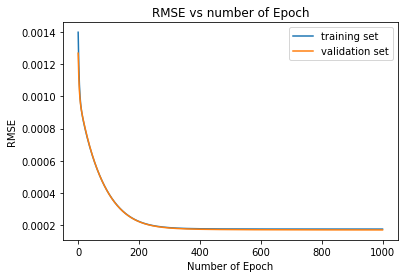

--- Total Training Time: 1.7873001098632812 (s) ---


In [19]:
# Q1
start_time = time.time() ## Records current time

rmse_direct = rmse(yPred_val, y_test)
CT = rmse_direct*1.001 # Convergence threshold
alpha = 0.01 # learning rate
w = (np.random.random(41)/10000).reshape(1,-1) # Inital weights
y_train = y_train.reshape(-1,1)

rmses_train,rmses_valid = [],[]
for epoch in range (0, 1000):
    ypred_train = np.dot(X_train_scaled,w.T).reshape (-1,1)
    rmses_train.append(rmse(ypred_train,y_train))
    gradient = (1/len(ypred_train) * np.dot(X_train_scaled.T, ypred_train-y_train)).reshape(1,-1) 
    w = w - alpha * gradient
    ypred_valid = np.dot(X_test_scaled, w.T)
    rmses_valid.append(rmse(ypred_valid,y_test))
    if rmse(ypred_valid,y_test) <= CT:
         break

plt.plot(rmses_train, label = 'training set')
plt.plot(rmses_valid, label = 'validation set')
plt.title("RMSE vs number of Epoch")
plt.xlabel("Number of Epoch")
plt.ylabel("RMSE")
plt.legend()
plt.show()
print("--- Total Training Time: %s (s) ---" % (time.time() - start_time))

Q2: In the first few Epoch, we have a underfitting problem since both the training and validation RMSE scores are high. As the number of Epoch increases, both training and validation set RMSE decreases, which means that the model generalizes data better and better. Once we pass the Convergence Threshold (CT), the model starts to overfitting because the model just memorize the data instead of generalize the data. 

The running time is not a problem here since the size of the dataset is not very large, but for some high dimension dataset, the full batch gradient descent approach may lead to a very long running time. 

The graph of RMSE vs the number of epoch is also quite smooth since we are averaging over all the gradients of training data for a single step. The RMSE score keep decreasing over the epochs.

## Part 4 - Mini-batch and Stochastic Gradient Descent [4 marks]

Write a function that performs mini-batch gradient descent until the convergence threshold (CT) is reached.**[1]** The inputs of that function are 
  * Training Data
  * Validation Data
  * Batch size
  * Learning Rate
  * Convergence Threshold (CT)
  * Maximum Iterations = 20000

Your function will return the following arrays: 
 * The final weights after training.
 * The training RMSE at each epoch (the number of epochs is the number of passes on the full data set).
 * The validation RMSE at each epoch.
 * An array that has the elapsed time from the start of the training process to the end of each epoch (e.g., if each epoch takes exactly 2 seconds the array would look like: [2 4 6 8 ...]).
 * For certain batchsizes GD might not converge to a solution. For that reason we have a parameter "Maximum iterations" where we limit the total number of iterations that this function can perform. 

Let's now use the function to investigate the effect of batch size on convergence. When the batch size is 1, we call that stochastic gradient descent. When the batch size equals the # of training data, it is full-batch (ie all data points are used at every iteration). Anywhere in between is mini-batch (we use some of the data).
  * Sweep different values for the mini-batch size (at least 10 values, including 1 -- Stochastic GD), each time using a learning rate of $\alpha= 1e-2$. **Hint: Try batch sizes that are powers of two (e.g., 2,4,8,16,32,...).** These batchsizes fit better on the hardware and may achieve higher performance.  **[0.5]**
  * Plot training and validation RMSE vs. **epoch** for all the batchsizes in a figure. The X-axis is Epoch # and the Y-axis is RMSE. **[0.5]**
  * Plot training and validation RMSE vs. **time** for all the batchsizes in a figure. The X-axis is Time and the Y-axis is RMSE. **[0.5]**
  * Plot Total training time (y-axis) vs. Batch size (x-axis). **[0.5]**
  * Describe your findings, including the main takeawyas from each of your plots. **[1]**

In [20]:
CT = rmse_direct*1.001
CT

0.00016971853283117094

In [28]:
def MinibatchGradientDescent(X_t,y_t,X_v,y_v,bs,CT,max_iterations,alpha):
    counts = 0
    rmses_v = 10
    CT = rmse_direct*1.001 # Convergence threshold
    m,n=X_t.shape
    rmses_train = []
    rmses_valid = []
    elapsed_time = []
    weights = []
    total_time = []
    start_time = time.time()
    np.random.seed(42)
    w = (np.random.random(41)/10000).reshape(1,-1) # Inital weights
    
    while counts <= max_iterations and rmses_v > CT:

        for i in range(0,m,bs):
            X_t_batched = X_t[i:i+bs,:]     
            y_t_batched = y_t[i:i+bs]
            h = np.dot(X_t_batched,w.T).reshape (-1,1)
            gradient = (1/(X_t_batched.shape[0]) * np.dot(X_t_batched.T, h - y_t_batched)).reshape(1,-1) 
            w = w - alpha * gradient
            counts = counts + 1
    
        elapsed_time.append(time.time() - start_time) # record elapsed time
        weights.append(w) # weights array for all epoch
        ypred_t = np.dot(X_t,w.T).reshape (-1,1)
        rmses_t = rmse(ypred_t,y_t) # training RMSE at each epoch 
        rmses_train.append(rmses_t)
        ypred_v = np.dot(X_v, w.T).reshape(-1,1)
        rmses_v = rmse(ypred_v,y_v) # validation RMSE at each epoch
        rmses_valid.append(rmses_v)

    total_t = elapsed_time[-1] # record total training time for each batch size
    total_time.append(total_t)
    final_w = weights[-1] # final weights after training 
    
    if counts > max_iterations:
        print('model diverges')
    else:
        print('model converges')       
    
    return rmses_train,rmses_valid,elapsed_time,final_w,total_time

model diverges


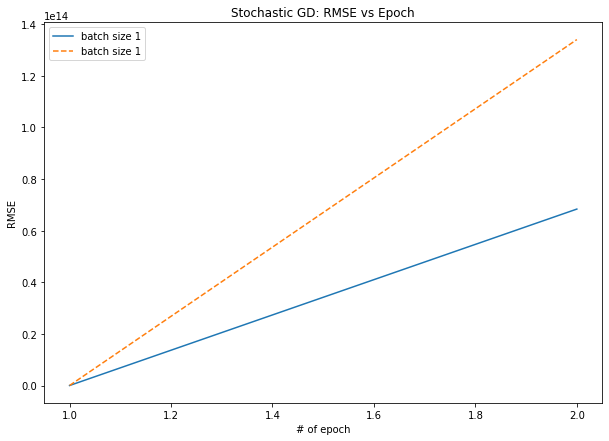

In [31]:
# Stochastic GD plot: training and validation RMSE vs. Epoch 
B = [1] 
plt.figure(figsize=(10,7))
for b in B:
    rmses_train,rmses_valid,elapsed_time,final_w,total_time=MinibatchGradientDescent(X_t=X_train_scaled,y_t=y_train,
                                                                                     X_v=X_test_scaled,y_v=y_test,
                                                                                     bs=b,CT=rmse_direct*1.001,
                                                                                     max_iterations=20000,alpha=0.01)
    plt.plot(np.arange(1, len(rmses_train)+1), 
             rmses_train,label = 'batch size {}'.format(b), linestyle = 'solid') # solid line for training set
    plt.plot(np.arange(1, len(rmses_valid)+1),
             rmses_valid,label = 'batch size {}'.format(b),linestyle = 'dashed') # dashed line for training set
    plt.xlabel('# of epoch')
    plt.ylabel('RMSE')
    plt.title('Stochastic GD: RMSE vs Epoch')
    plt.legend()

model converges
model converges
model converges
model converges
model converges
model converges
model converges
model converges
model converges


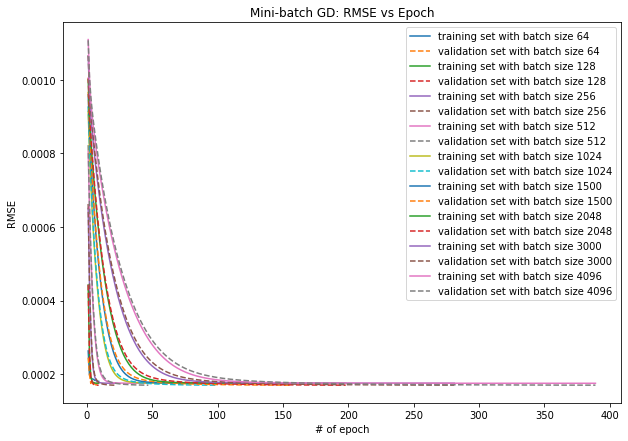

In [32]:
# Mini-batch plot: training and validation RMSE vs. Epoch 
B = [64,128,256,512,1024,1500,2048,3000,4096] # try different batch size
plt.figure(figsize=(10,7))
for b in B:
    rmses_train,rmses_valid,elapsed_time,final_w,total_time=MinibatchGradientDescent(X_t=X_train_scaled,y_t=y_train,
                                                                                     X_v=X_test_scaled,y_v=y_test,
                                                                                     bs=b,CT=rmse_direct*1.001,
                                                                                     max_iterations=20000,alpha=0.01)
    plt.plot(np.arange(1, len(rmses_train)+1), 
             rmses_train,label = 'training set with batch size {}'.format(b), linestyle = 'solid') # solid line for training set
    plt.plot(np.arange(1, len(rmses_valid)+1),
             rmses_valid,label = 'validation set with batch size {}'.format(b),linestyle = 'dashed') # dashed line for validation set
    plt.xlabel('# of epoch')
    plt.ylabel('RMSE')
    plt.title('Mini-batch GD: RMSE vs Epoch')
    plt.legend()

model converges
model converges
model converges
model converges
model converges
model converges
model converges
model converges
model converges


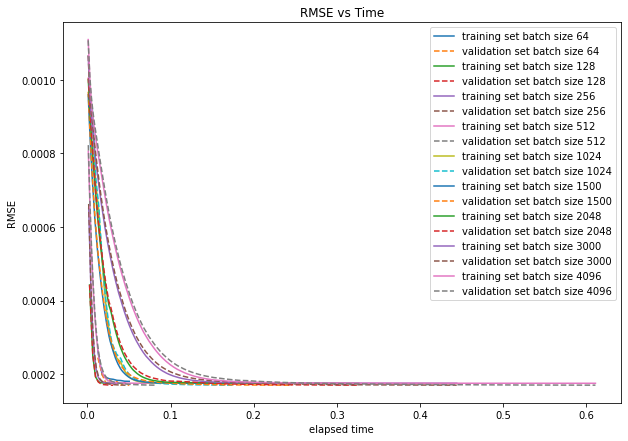

In [33]:
# Training and validation RMSE vs. time plot
B = [64,128,256,512,1024,1500,2048,3000,4096]
plt.figure(figsize=(10,7))
for b in B:
    rmses_train,rmses_valid,elapsed_time,final_w,total_time=MinibatchGradientDescent(X_t=X_train_scaled,y_t=y_train,
                                                                                     X_v=X_test_scaled,y_v=y_test,
                                                                                     bs=b,CT=rmse_direct*1.001,
                                                                                     max_iterations=20000,alpha=0.01)
    plt.plot(elapsed_time, 
             rmses_train,label = 'training set batch size {}'.format(b), linestyle = 'solid') # solid line for training set
    plt.plot(elapsed_time,
             rmses_valid,label = 'validation set batch size {}'.format(b),linestyle = 'dashed') # dashed line for validation set
    plt.xlabel('elapsed time')
    plt.ylabel('RMSE')
    plt.title('RMSE vs Time')
    plt.legend()

model converges
model converges
model converges
model converges
model converges
model converges
model converges
model converges
model converges


Text(0.5, 1.0, 'Batch Size vs Total Training Time')

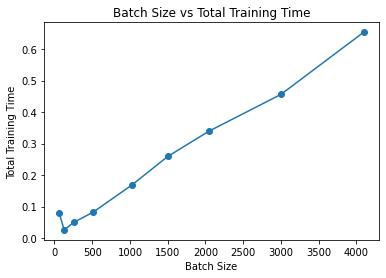

In [36]:
# Total training time (y-axis) vs. Batch size (x-axis) plot 
B = [64,128,256,512,1024,1500,2048,3000,4096] # only plot converge model here
total_time_array = []
for b in B:
    rmses_train,rmses_valid,elapsed_time,final_w,total_time=MinibatchGradientDescent(X_t=X_train_scaled,y_t=y_train,
                                                                                     X_v=X_test_scaled,y_v=y_test,
                                                                                     bs=b,CT=rmse_direct*1.001,
                                                                                     max_iterations=20000,alpha=0.01)
    total_time_array.append(total_time)

plt.plot([64,128,256,512,1024,1500,2048,3000,4096], total_time_array, marker='o')
plt.plot()
plt.xlabel('Batch Size')
plt.ylabel('Total Training Time')
plt.title('Batch Size vs Total Training Time')

**Describe findings for each graph above:**

Stochastic Gradient Descent graph: RMSE vs # of Epoch

In Stochastic GD, we consider one example at a time to take a single step. The cost function was fluctuating over the training examples and it is not always moving to the right direction. In other words, it may not going to converge at a certain point just like in this dataset: the model diverges when the batch size equals to one. 

Mini-Batch Gradient Descent graph: RMSE vs # of Epoch

In the Mini-Batch GD, we used a fixed number of training examples for each batch. In each epoch, we pick a mini-batch size, calculate the mean gradient of each mini-batch then use it to update the weight, and repeat the steps for all mini-batches. From the graph, we can see that the model converges faster when using smaller mini-batch size, model converges slower when using larger mini-batch size. The reason behind this is: for smaller batch size, it will create more noise than a large batch size. The noise can help us jump out of a bad local minima and find a better local minima. So, small batch size model leads to a smaller number of iterations and also smaller number of epoch than larger batch size model. 

Mini-Batch Gradient Descent graph: RMSE vs Time

From the graph, we can conclude that for smaller batch size, the model converge quickly than larger batch size. The reason for this is that the noise created in smaller batch size model will help us jump out of a bad local minima and find a better local minima, and we can move faster towards the optimal point. Therefore, smaller batch size model use less training time than larger batch size model. 

Batch size vs Total training time graph

From the graph, we can see that the total training time increases as the nunmber of batch size increases. The reason is the same as I mentioned above: smaller batch size model will help us jump out of a bad local minima and find a better local minima, and we can move faster towards the optimal point. Therefore, smaller batch size model use less total training time than larger batch size model. The best batch size which can lead to shortest training time is 128. 

## Part 5 - Gradient Descent Learning Rate [2 marks]
Use the function that you designed in Part 4 to investigate the effect of learning rate on convergence.

Select the best batch size based on the fastest convergence time and sweep the learning rate (at least 10 values) while applying Mini-batch GD. 
  1. Plot the training and validation RMSE vs **epoch** (x-axis) for all the learning rates that you tried in a figure. **[0.5]**
  2. Plot the training and validation RMSE vs **time** (x-axis) for all the learning rates that you tried in a figure. **[0.5]**
  3. Describe your findings, including the main takeawyas from each of your plots. **[1]**


In [37]:
# find the best batch size which takes lowest time to converge
min_index = list(total_time_array).index(min(total_time_array))
print('The best batch size based on the fastest convergence time is', B[min_index])

The best batch size based on the fastest convergence time is 128


model converges
model converges
model converges
model converges
model converges
model converges
model converges
model converges
model converges
model converges


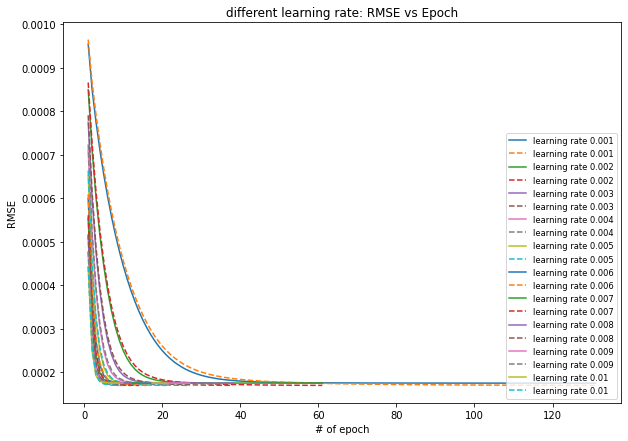

In [38]:
# training and validation RMSE vs. Epoch for all learning rate

A = [0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009,0.01]
plt.figure(figsize=(10,7))
for a in A:
    rmses_train,rmses_valid,elapsed_time,final_w,total_time=MinibatchGradientDescent(X_t=X_train_scaled,y_t=y_train,
                                                                                     X_v=X_test_scaled,y_v=y_test,
                                                                                     bs=128,CT=rmse_direct*1.001,
                                                                                     max_iterations=20000,alpha=a)
    plt.plot(np.arange(1, len(rmses_train)+1), 
             rmses_train,label = 'learning rate {}'.format(a), linestyle = 'solid') # solid line for training set
    plt.plot(np.arange(1, len(rmses_valid)+1),
             rmses_valid,label = 'learning rate {}'.format(a),linestyle = 'dashed') # dashed line for training set
    plt.xlabel('# of epoch')
    plt.ylabel('RMSE')
    plt.title('different learning rate: RMSE vs Epoch')
    plt.legend(loc = 'lower right', fontsize = 'small')

model converges
model converges
model converges
model converges
model converges
model converges
model converges
model converges
model converges
model converges


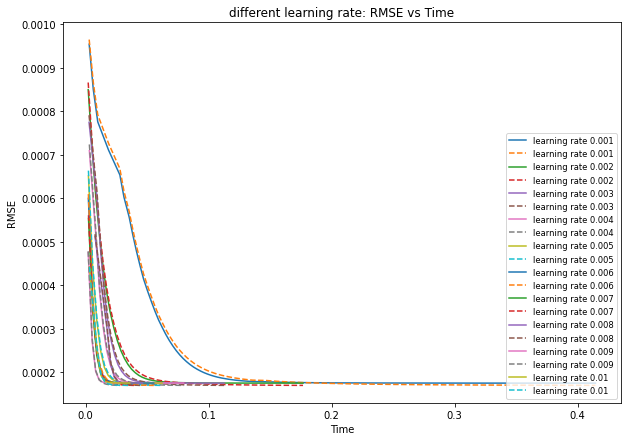

In [39]:
# training and validation RMSE vs. Time for all learning rate
A = [0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009,0.01]
plt.figure(figsize=(10,7))
total_time_array5 = []
for a in A:
    rmses_train,rmses_valid,elapsed_time,final_w,total_time=MinibatchGradientDescent(X_t=X_train_scaled,y_t=y_train,
                                                                                     X_v=X_test_scaled,y_v=y_test,
                                                                                     bs=128,CT=rmse_direct*1.001,
                                                                                     max_iterations=20000,alpha=a)
    total_time_array5.append(total_time)
    plt.plot(elapsed_time, 
             rmses_train,label = 'learning rate {}'.format(a), linestyle = 'solid') # solid line for training set
    plt.plot(elapsed_time,
             rmses_valid,label = 'learning rate {}'.format(a),linestyle = 'dashed') # dashed line for training set
    plt.xlabel('Time')
    plt.ylabel('RMSE')
    plt.title('different learning rate: RMSE vs Time')
    plt.legend(loc = 'lower right', fontsize = 'small')

In [41]:
# find the best learning rate which takes lowest time to converge
min_index = list(total_time_array5).index(min(total_time_array5))
print('The best learning rate based on the fastest convergence time is', A[min_index])
P5_bestT = min(total_time_array5)[0]
print('The fastest convergence takes', P5_bestT)

The best learning rate based on the fastest convergence time is 0.009
The fastest convergence takes 0.027756929397583008


**Describe findings for each graph**

Different learning rate: RMSE vs # of Epoch graph

The pattern in the graph is that larger learning rate model has fewer number of epoches, smller learning rate model has larger number of epoches. The reason behind this is that smaller learning rate model gives smaller changes to weight in each update. Thus, it requires more epochs to converge. For larger learning rate model, it provide larger changes to weight in each update. Thus, larger learning rate model requires fewer number of epoches.

Different learning rate: Time vs # of Epoch graph

From the graph, we can see that large learning rate model takes less time to converge, while small learning rate model takes more time to converge. The logic behind this is: For large learning rate model, it provide larger change changes to weight in each update, so it takes a longer time to converge. For small learning rate model, it gives smaller changes to weight in each update, so it takes less time to converge.

## Part 6 - Gradient Descent with Adaptive Learning Rate [4 marks]
Implement an adaptive learning rate scheme where you start a mini-batch gradient descent with a large learning rate and decrease the learning rate while you are getting closer to the local minima. It's up to you to come up with a way to set **when** and **how much** do you want to change the learning rate. 
Our goal is to find a method for faster convergence. 
  1. Describe **[1]** and implement **[1]** your method.
  2. Plot the training and validation RMSE vs **epoch** for your method (adaptive learning rate), alongside your best training run from Part 5 (static learning rate). **[1]**
  3. Plot the training and validation RMSE vs **time** for your method (adaptive learning rate), alongside your best training run from Part 5 (static learning rate). **[1]**

**Describe method**

I fixed the batch size as 128 which is the best batch size I found in previous part, and I start with a large learning rate 0.1 which lead to model to diverge, and then decrease learning rate by 0.01 once the RMSE of validation set score falls into the region (CT, CT_u). When the model converges (RMSE for validation set is below than CT) and also the training time is less than the previous part (P5_bestT), we reaches the optimal situation. If the number of iterations(counts) is greater then 20000(max_iterations), the model diverges, we should lower the learning rate by 0.01 as well. 

**The method is shown below**

In [43]:
counts = 0
rmses_v = 10
CT = rmse_direct*1.001 # Convergence threshold
CT_u = CT*1.1
m,n=X_train_scaled.shape
total_time = []
alpha = 0.1 # start with learning rate = 0.1
max_iterations = 20000
np.random.seed(0)

while True:  

    elapsed_time = []
    rmses_train = []
    rmses_valid = []
    w = (np.random.random(41)/10000).reshape(1,-1) # Inital weights
    counts = 0
    rmses_v = 10
    start_time = time.time()
    while counts <= max_iterations and rmses_v > CT:

        for i in range(0,m,128):
            X_t_batched = X_train_scaled[i:i+128,:]     
            y_t_batched = y_train[i:i+128]
            h = np.dot(X_t_batched,w.T).reshape (-1,1)
            gradient = (1/(X_t_batched.shape[0]) * np.dot(X_t_batched.T, h - y_t_batched)).reshape(1,-1) 
            w = w - alpha * gradient
            counts = counts + 1

        elapsed_time.append(time.time() - start_time)
        ypred_t = np.dot(X_train_scaled,w.T).reshape (-1,1)
        rmses_train.append(rmse(ypred_t,y_train))
        ypred_v = np.dot(X_test_scaled, w.T).reshape(-1,1)
        rmses_v = rmse(ypred_v,y_test)
        rmses_valid.append(rmses_v)
    total_t = elapsed_time[-1]
    total_time.append(total_t)

    if (rmses_v < CT_u) & (rmses_v > CT) & (total_t > P5_bestT):
        alpha = alpha - 0.01

    elif counts > max_iterations:
        print('model diverges when learning rate is', alpha)
        alpha = alpha - 0.01

    elif total_t < P5_bestT:
        print('optimal model when learning rate is', alpha, 'which takes',total_t)
        break

model diverges when learning rate is 0.1
model diverges when learning rate is 0.09000000000000001
model diverges when learning rate is 0.08000000000000002
model diverges when learning rate is 0.07000000000000002
model diverges when learning rate is 0.06000000000000002
model diverges when learning rate is 0.05000000000000002
model diverges when learning rate is 0.040000000000000015
model diverges when learning rate is 0.030000000000000013
optimal model when learning rate is 0.01000000000000001 which takes 0.02482008934020996


model converges


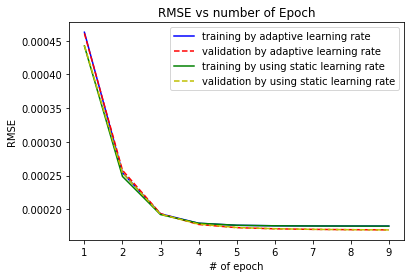

In [44]:
# RMSE vs epoch for adaptive learning rate vs static learning rate
rmses_train5,rmses_valid5,elapsed_time5,final_w5,total_time5=MinibatchGradientDescent(X_t=X_train_scaled,y_t=y_train,
                                                                                 X_v=X_test_scaled,y_v=y_test,
                                                                                 bs=128,CT=rmse_direct*1.001,
                                                                                 max_iterations=20000,alpha=0.01)
plt.plot(np.arange(1, len(rmses_train)+1), 
          rmses_train,label = 'training by adaptive learning rate', linestyle = 'solid', color = 'B')  # adaptive learning rate (train)
plt.plot(np.arange(1, len(rmses_valid)+1),
          rmses_valid,label = 'validation by adaptive learning rate', linestyle = 'dashed', color = 'R') # adaptive learning rate (validation)
plt.plot(np.arange(1, len(rmses_train5)+1), 
          rmses_train5,label = 'training by using static learning rate', linestyle = 'solid', color = 'G') # static learning rate from part 5 (train)
plt.plot(np.arange(1, len(rmses_valid5)+1),
          rmses_valid5,label = 'validation by using static learning rate',linestyle = 'dashed', color = 'y') # static learning rate from part 5(validatoin)
plt.xlabel('# of epoch')
plt.ylabel('RMSE')
plt.title('RMSE vs number of Epoch')
plt.legend()

model converges


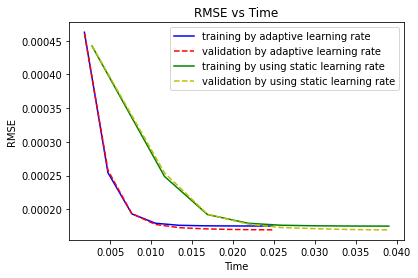

In [45]:
# RMSE vs Time for adaptive learning rate vs static learning rate
rmses_train5,rmses_valid5,elapsed_time5,final_w5,total_time5=MinibatchGradientDescent(X_t=X_train_scaled,y_t=y_train,
                                                                                 X_v=X_test_scaled,y_v=y_test,
                                                                                 bs=128,CT=rmse_direct*1.001,
                                                                                 max_iterations=20000,alpha=0.01)
plt.plot(elapsed_time, 
         rmses_train,label = 'training by adaptive learning rate', linestyle = 'solid', color = 'B') # adaptive learning rate (train)
plt.plot(elapsed_time,
         rmses_valid,label = 'validation by adaptive learning rate', linestyle = 'dashed', color = 'R') # adaptive learning rate (validation)
plt.plot(elapsed_time5, 
         rmses_train5,label = 'training by using static learning rate', linestyle = 'solid', color = 'G') # static learning rate from part 5 (train)
plt.plot(elapsed_time5,
         rmses_valid5,label = 'validation by using static learning rate',linestyle = 'dashed', color = 'y') # static learning rate from part 5 (validation)
plt.xlabel('Time')
plt.ylabel('RMSE')
plt.title('RMSE vs Time')
plt.legend()

## Part 7 - Gradient Descent with Additional Features and Regularization [3 marks]

Now, we'll apply linear regresssion to a toy dataset (`LR_data.csv`), with 10 features `x1`-`x10` and a "measurement" `y`. We'll take a few shortcuts by using built-in sklearn functions.

1. Data Preparation **[0.5]**
  * Print the dataset, and create Numpy arrays with inputs (X) and outputs (y). 
  * Split the dataset into training and validation sets (80% training, 20% validation). When splitting, set `random_state=1`.

2. Linear Regression **[0.5]**
  * Standardize the data using StandardScaler from sklearn.
  * Use the `sklearn.linear_model.LinearRegression` function [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) to perform linear regression.
  * Print the RMSE for training and validation data.

3. Linear Regression with Additional Features **[0.5]**
  * Let's add more features to our dataset (up to degree 8) using `sklearn.preprocessing.PolynomialFeatures` [here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html). You'll want to create the additional features first, then perform standardization (start from non-standardized data).
  * Again, use `sklearn.linear_model.LinearRegression` to perform linear regression.
  * Print the RMSE for training and validation data.

4. Linear Regression with Additional Features and Regularization **[0.5]**
  * Let's switch models, and instead use the `sklearn.linear_model.Ridge` function [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge) to perform linear regression with regularization. Apply the model to the processed data (additional, standardized) you used in 3 above. Use a `FOR` loop to run `sklearn.linear_model.Ridge` with different `alpha` values. Specifically, sweep `alpha` from 1E-2 to 1E10 (each step is an order of magnitude jump).

5. Discuss your results. What do you conclude? **[1]**

In [83]:
# Q1-Data Prepartion
import pandas as pd
df=pd.read_csv("https://www.eecg.utoronto.ca/~hadizade/APS1070/LR_data.csv" , skipinitialspace=True)
df

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,y
0,1.454481,4.940543,7.116015,3.805131,4.105432,1.832290,5.211909,5.088293,3.841250,6.121133,6.575066e+06
1,4.907182,1.653654,7.339445,9.065282,7.169233,2.354136,2.893005,8.720131,8.646473,3.806860,8.419881e+06
2,1.842804,1.183878,4.203206,6.815847,6.655899,8.295816,3.556779,5.794679,3.260723,5.463808,9.745537e+04
3,2.393457,0.094127,3.208929,0.497443,4.318127,4.999247,9.470238,3.061990,7.312995,5.475240,1.129200e+04
4,5.093724,3.905293,4.858562,4.465484,0.947091,9.410307,8.137329,9.043838,9.128607,0.790795,3.105448e+05
...,...,...,...,...,...,...,...,...,...,...,...
195,2.936450,2.094812,9.493814,3.411240,4.350940,0.386062,1.303290,2.699563,7.622569,3.037162,6.599726e+07
196,4.915597,1.953974,7.312552,9.331203,1.329366,8.286760,5.233018,7.476923,7.043560,5.745565,8.176250e+06
197,6.772096,6.406489,4.638352,7.042340,0.912338,7.568296,1.194928,2.592840,9.386478,4.147710,2.144147e+05
198,3.940339,4.330498,6.693371,9.169265,0.858846,0.601942,2.635455,2.037859,7.883720,8.525164,4.028735e+06


In [84]:
# Split the dataset into training and validation sets 
y = df['y'].values
X = df.drop('y', axis = 1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [85]:
# Standardization
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [86]:
# Q2-Linear Regression
reg = LinearRegression().fit(X_train_scaled, y_train)
ypred_t = reg.predict(X_train_scaled)
print('rmse for training set is',rmse(ypred_t, y_train))
ypred_v = reg.predict(X_test_scaled)
print('rmse for validation set is',rmse(ypred_v, y_test))

rmse for training set is 16296980.655667372
rmse for validation set is 14061578.864980105


In [87]:
# Q3-Linear Regression with Additional Features
poly = PolynomialFeatures(8)
trans = poly.fit(X_train, y_train)
df1 = pd.DataFrame(trans.transform(X_train))
df2 = pd.DataFrame(trans.transform(X_test))

In [88]:
# Standardization
scaler = StandardScaler().fit(df1.values)
X_train_scaled = scaler.transform(df1.values)
X_test_scaled = scaler.transform(df2.values)

In [89]:
# Linear Regression
reg = LinearRegression().fit(X_train_scaled, y_train)
ypred_t = reg.predict(X_train_scaled)
print('rmse for training set with additional features is',rmse(ypred_t, y_train))
ypred_v = reg.predict(X_test_scaled)
print('rmse for validation set with additional features is',rmse(ypred_v, y_test))

rmse for training set with additional features is 1.1154878119198678e-07
rmse for validation set with additional features is 10920908.905406754


In [90]:
# Q4-Linear Regression with Additional Features and Regularization 
rmses_train, rmses_validation = [], []
for alpha in [0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000, 10000000, 100000000 ,1000000000, 10000000000]:
    R = Ridge(alpha)
    R.fit(X_train_scaled, y_train)
    ypred_T = R.predict(X_train_scaled)
    rmse_T = rmse(ypred_T, y_train)
    rmses_train.append(rmse_T)
    ypred_V = R.predict(X_test_scaled)
    rmse_V = rmse(ypred_V, y_test)
    rmses_validation.append(rmse_V)
    print('RMSE for training set is', rmse_T, 'when alpha is {}'.format(alpha)) 
    print('RMSE for validation set is', rmse_V, 'when alpha is {}'.format(alpha))
print("The lowest RMSE for validaton set we can achieve is", min(rmses_validation))

RMSE for training set is 321.01240916309644 when alpha is 0.01
RMSE for validation set is 10919504.125893764 when alpha is 0.01
RMSE for training set is 3199.3496468416506 when alpha is 0.1
RMSE for validation set is 10916171.329033064 when alpha is 0.1
RMSE for training set is 30988.518341657847 when alpha is 1
RMSE for validation set is 10884651.018827904 when alpha is 1
RMSE for training set is 248080.3696494477 when alpha is 10
RMSE for validation set is 10659707.103878867 when alpha is 10
RMSE for training set is 1196923.6228686073 when alpha is 100
RMSE for validation set is 9484394.22011948 when alpha is 100
RMSE for training set is 3609078.2596920887 when alpha is 1000
RMSE for validation set is 5633182.875138311 when alpha is 1000
RMSE for training set is 7712389.432217537 when alpha is 10000
RMSE for validation set is 4521905.583502402 when alpha is 10000
RMSE for training set is 14600498.520348776 when alpha is 100000
RMSE for validation set is 10502863.775565729 when alpha 

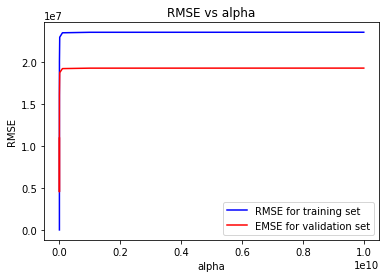

In [91]:
# plot RMSE vs different alpha
plt.plot([0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000, 10000000, 100000000 ,1000000000, 10000000000], 
         rmses_train, color = 'B', label = "RMSE for training set")
plt.plot([0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000, 10000000, 100000000 ,1000000000, 10000000000], 
         rmses_validation, color = 'R', label = "EMSE for validation set")
plt.xlabel("alpha")
plt.ylabel("RMSE")
plt.title("RMSE vs alpha")
plt.legend()

**Discuss results**

The RMSE score for validation set before adding additional features is 14061578.864980105, the RMSE of validation set after adding addtional features by fitting PolynomialFeatures to degree 8 is 10920908.905406754, which isn't improve much. The RMSE of training set is only1.1154878119198678e-07, it looks like we have an overfitting problem, since the model has a low training error and a high test error. The model almost captures all the pattern of the data, it fails to generalize on unseen data. 

For Ridge regularization: From the above graph we can see that RMSE for both training and validation set keeps increasing, and after alpha = 100000, it does not change much. The lowest RMSE of validation set we can get is 4521905.583502402, which impoves a little but not very much. The logic behind Ridge regularization is that L2 regularization adds penalty for having large weights, it only helps us prevent the overfitting problem a little bit in this dataset. 

## Part 8 - Linear Regression with a Custom Dataset [2 marks]


Find a dataset online and train and validate a linear regression model with the techniques you learned in this Project.

*   Introduce your dataset.**[0.5]**
*   Explain your approach. **[0.5]**
*   Summarize your results. **[1]**

Hint: you can find various datasets in here: https://www.kaggle.com/datasets.

To use a dataset in Colab, you can upload it in your Google drive and access it in Colab ([help here](https://medium.com/analytics-vidhya/how-to-fetch-kaggle-datasets-into-google-colab-ea682569851a)), or you can download the dataset on your local machine and upload it directly to Colab using the following script.

```
from google.colab import files
uploaded = files.upload()
```

When submitting your project on Quercus, Please make sure you are also uploading your dataset so we can fully run your notebook.






**Dataset Introduction**

I used Boston House Price dataset in part 8. The dataset include 506 samples, 13 features(X) and 1 target column("MEDV"). Here is the brief introduction for each features:
1. CRIM per capital crime rate by town
2. ZN proportion of residential land zoned for lots over 25,000 sq.ft.
3. INDUS proportion of non-retail business acres per town
4. CHAS Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
5. NOX nitric oxides concentration (parts per 10 million)
6. RM average number of rooms per dwelling
7. AGE proportion of owner-occupied units built prior to 1940
8. DIS weighted distances to five Boston employment centers
9. RAD index of accessibility to radial highways
10.TAX full-value property-tax rate per 10,000 USD
11. PTRATIO pupil-teacher ratio by town
12. Black 1000(Bk — 0.63)² where Bk is the proportion of blacks by town
13. LSTAT % lower status of the population

We are trying to use those features to predict house price in Boston.

In [58]:
# Import dataset
from sklearn.datasets import load_boston
boston_dataset = load_boston()
df = pd.DataFrame(boston_dataset.data, columns = boston_dataset.feature_names)
df['MEDV'] = boston_dataset.target
df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0


**Approach Explanation**

After importing the dataset, I first check if there are nans in the dataset, split the dataset for training(80%) and validation set(20%), and then I standardize the data by using StandardScaler from sklearn, which let all features in the same scale. Then I try to add more features by using PolynomialFeatures in order to see if there is a improvement in the RMSE score. Lastly, I used Ridge regularizer to see if there is any further improvement in the RMSE score. 

In [59]:
# check for null
df.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

In [60]:
# Split the dataset into training and validation sets with training set(80%), validation set(20%), setting random_state = 1
y = df['MEDV'].values
X = df.drop('MEDV', axis = 1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [63]:
# Standardization
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [64]:
# Perform Linear Regression and find RMSE for training and validation data
reg = LinearRegression().fit(X_train_scaled, y_train)
ypred_t = reg.predict(X_train_scaled)
print('rmse for training set is',rmse(ypred_t, y_train))
ypred_v = reg.predict(X_test_scaled)
print('rmse for validation set is',rmse(ypred_v, y_test))

rmse for training set is 4.675766751547773
rmse for validation set is 4.835373458200537


In [67]:
# Perform Linear Regression with Additional Features
trainRMSE, validationRMSE = [],[]

degree = [2,3,4,5,6,7]
for i in degree: # try degree equals to 1,2,3,4,5,6,7
    
    poly = PolynomialFeatures(i)
    trans = poly.fit(X_train, y_train)
    df1 = pd.DataFrame(trans.transform(X_train))
    df2 = pd.DataFrame(trans.transform(X_test))
    # Standardization
    scaler = StandardScaler().fit(df1.values)
    X_train_scaled = scaler.transform(df1.values)
    X_test_scaled = scaler.transform(df2.values)
    # Linear Regression
    reg = LinearRegression().fit(X_train_scaled, y_train)
    ypred_t = reg.predict(X_train_scaled)
    rmse_t = rmse(ypred_t, y_train)
    trainRMSE.append(rmse_t)
    print('rmse for training set is', rmse_t, 'degree is {}'.format(i))
    ypred_v = reg.predict(X_test_scaled)
    rmse_v = rmse(ypred_v, y_test)
    validationRMSE.append(rmse_v)
    print('rmse for validation set is', rmse_v, 'degree is {}'.format(i))

rmse for training set is 2.4382638501906464 degree is 2
rmse for validation set is 2.9553221974322987 degree is 2
rmse for training set is 1.6519041935543564e-11 degree is 3
rmse for validation set is 39.92167278242836 degree is 3
rmse for training set is 8.831618635521033e-13 degree is 4
rmse for validation set is 17.039677434265016 degree is 4
rmse for training set is 3.0231564850981215e-13 degree is 5
rmse for validation set is 14.37040340343727 degree is 5
rmse for training set is 2.8965037404713923e-13 degree is 6
rmse for validation set is 13.404871124463941 degree is 6
rmse for training set is 3.016449358995196e-13 degree is 7
rmse for validation set is 12.854028835439216 degree is 7


In [72]:
print("The minimum RMSE of validation set we can get is", min(validationRMSE), 'when degree is', degree[list(validationRMSE).index(min(validationRMSE))])

The minimum RMSE of validation set we can get is 2.9553221974322987 when degree is 2


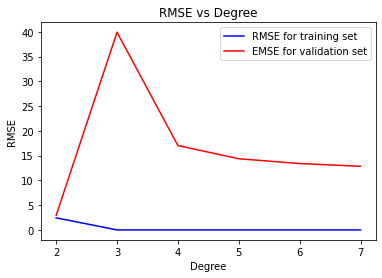

In [73]:
# plot RMSE vs different degree
plt.plot([2,3,4,5,6,7], trainRMSE, color = 'B', label = "RMSE for training set")
plt.plot([2,3,4,5,6,7], validationRMSE, color = 'R', label = "EMSE for validation set")
plt.xlabel("Degree")
plt.ylabel("RMSE")
plt.title("RMSE vs Degree")
plt.legend()

In [74]:
# Ridge
poly = PolynomialFeatures(2)
trans = poly.fit(X_train, y_train)
df1 = pd.DataFrame(trans.transform(X_train))
df2 = pd.DataFrame(trans.transform(X_test))

In [75]:
# Standardization
scaler = StandardScaler().fit(df1.values)
X_train_scaled = scaler.transform(df1.values)
X_test_scaled = scaler.transform(df2.values)

In [81]:
# Linear Regression
reg = LinearRegression().fit(X_train_scaled, y_train)
ypred_t = reg.predict(X_train_scaled)
print('rmse for training set is', rmse(ypred_t, y_train))
ypred_v = reg.predict(X_test_scaled)
print('rmse for validation set is', rmse(ypred_v, y_test))

rmse for training set is 2.4382638501906464
rmse for validation set is 2.9553221974322987


In [78]:
rmses_train, rmses_validation = [], []
A = [0.01, 0.1, 1, 10, 100, 1000]
for alpha in A:
    R = Ridge(alpha)
    R.fit(X_train_scaled, y_train)
    ypred_T = R.predict(X_train_scaled)
    rmse_T = rmse(ypred_T, y_train)
    rmses_train.append(rmse_T)
    ypred_V = R.predict(X_test_scaled)
    rmse_V = rmse(ypred_V, y_test)
    rmses_validation.append(rmse_V)
    print('RMSE for training set is', rmse_T, 'when alpha is {}'.format(alpha))
    print('RMSE for test set is', rmse_V, 'when alpha is {}'.format(alpha))

RMSE for training set is 2.451653912873174 when alpha is 0.01
RMSE for test set is 2.942143632682284 when alpha is 0.01
RMSE for training set is 2.5365723281996755 when alpha is 0.1
RMSE for test set is 2.8793317172932014 when alpha is 0.1
RMSE for training set is 2.8084248031553507 when alpha is 1
RMSE for test set is 2.665803545783918 when alpha is 1
RMSE for training set is 3.3156648420365937 when alpha is 10
RMSE for test set is 3.0911581630901024 when alpha is 10
RMSE for training set is 4.136070690761368 when alpha is 100
RMSE for test set is 4.246691581935399 when alpha is 100
RMSE for training set is 4.987625028441566 when alpha is 1000
RMSE for test set is 5.560290408088875 when alpha is 1000


In [80]:
print("The minimum RMSE of validation set we can get is", min(rmses_validation), 'when alpha is', A[list(rmses_validation).index(min(rmses_validation))])

The minimum RMSE of validation set we can get is 2.665803545783918 when alpha is 1


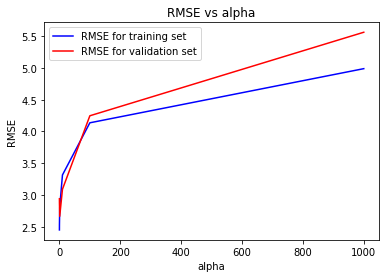

In [82]:
# plot RMSE vs different alpha
plt.plot([0.01, 0.1, 1, 10, 100, 1000], rmses_train, color = 'B', label = "RMSE for training set")
plt.plot([0.01, 0.1, 1, 10, 100, 1000], rmses_validation, color = 'R', label = "RMSE for validation set")
plt.xlabel("alpha")
plt.ylabel("RMSE")
plt.title("RMSE vs alpha")
plt.legend()

**Conclusion**

The RMSE for original dataset after standardization is 4.675766751547773 (training set) and 4.835373458200537 (validation set). Then I tried to add more feautres using PolynominalFeatures, and I found the model with degree 2 leads to a lower RMSE for validation set(2.9553221974322987) and also lower RMSE for training set(2.4382638501906464). For larger degree, we have a overfitting problem since the training error is low but validation error is high, the model is too complex and it does generalize the whole data. After that, I used dataset with degree 2 and adds Ridge regularizer to see if there is any further improvement. By sweeping alpha value for 0.01, 0.1, 1, 10, 100, 1000, the minimum validation set RMSE we can get is 2.665803545783918, which is lower than before. Overall, if we  set degree to 2 and alpha to 1, we can decrease RMSE of validation set from 4.835373458200537 to 2.665803545783918, the polynominalFeatures function and Ridge regularization does help model performance (decrease RMSE in validation set). 